<a href="https://colab.research.google.com/github/zyntonyson/Erisk2017/blob/master/02_BoW_W2V_SVM_Early_detection_depression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Cargar datos




In [0]:
import os
mypath='/content/drive/My Drive/MCE/Participaciones/05.Estancia Jun19/Practicas NLP/Deteccion de depresion/Actualizacion sep 2019'
os.chdir( mypath )

In [0]:
import pandas as pd
import numpy as np

train_df=pd.read_csv('train_Depression_all_chunks_nosteem.csv')
train_df=train_df.replace(np.nan, '', regex=True)
test_df=pd.read_csv('test_Depression_all_chunks_nosteem.csv')
test_df=test_df.replace(np.nan, '', regex=True)

In [0]:
def generate_data(df,nchunks=1):
  data=df['Chunk_1']
  data.rename(columns={'Chunk_1': 'x'})
  if nchunks<=1:
   pass
  else:
    for i in range(2,nchunks):
      chunk='Chunk_'+str(i)
      data+=df[chunk]
  return data.values



## SVM-BoW


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [0]:
def svm_bow(train,test,nChunks=1):

  # Generar datos
  x_train=generate_data(train,nChunks)
  y_train=train['Depress'].values
  x_test=generate_data(test,nChunks)
  y_test=test['Depress'].values
 
 #  Ajustar clasificador
  vectorizer=CountVectorizer( max_features=1000 )
  clf = LinearSVC(tol=1e-5,C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
         intercept_scaling=1, loss='squared_hinge', max_iter=1000,
         multi_class='ovr', penalty='l2', random_state=1013, verbose=2)
  
  # Realizar bolsa de palabras
  X_train=vectorizer.fit_transform(x_train)
  X_test=vectorizer.transform(x_test)

  # Entrenar
  clf.fit(X_train, y_train)

  # Predecir para prueba

  pred_test=clf.predict(X_test)

  # Metricas
  acc=metrics.accuracy_score(y_test,pred_test)
  f1_score_w=metrics.f1_score(y_test,pred_test,average='weighted')
  recall_score=metrics.recall_score(y_test,pred_test,average='macro')
  
  my_metrics=[nChunks,acc, f1_score_w,recall_score]
  
  return [round(metric,4) for metric in my_metrics]


In [0]:
bow_svm_metrics=np.zeros(shape=(10,4))

for chunk in range(1,11):
  tic=time.time()
  bow_svm_metrics[chunk-1,]=svm_bow(train_df,test_df,chunk)
  print('# Chunks: { } \t Tiempo de procesamiento (secs):{} '.format(chunk,time.time()-tic))
  

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [0]:
BowSVM_metrics=pd.DataFrame(bow_svm_metrics, columns=['Chunk','Acc','F1Score','Recall'])
BowSVM_metrics

,Chunk,Acc,F1Score,Recall
0,1.0,0.7905,0.8032,0.6096
1,2.0,0.7905,0.8032,0.6096
2,3.0,0.8080,0.8191,0.6442
3,4.0,0.8030,0.8155,0.6413
4,5.0,0.8005,0.8166,0.6645
5,6.0,0.8155,0.8245,0.6485
6,7.0,0.8155,0.8256,0.6567
7,8.0,0.8155,0.8256,0.6567
8,9.0,0.8155,0.8234,0.6403
9,10.0,0.8155,0.8234,0.6403


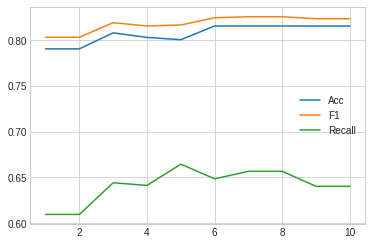

In [0]:
plt.style.use('seaborn-whitegrid')
plt.plot(BowSVM_metrics.Chunk,BowSVM_metrics.Acc, label='Acc')
plt.plot(BowSVM_metrics.Chunk,BowSVM_metrics.F1Score,label='F1')
plt.plot(BowSVM_metrics.Chunk,BowSVM_metrics.Recall,label='Recall')
plt.legend()

## SVM-Tf-Idf


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [0]:
def svm_tfidf(train,test,nChunks=1):
  
  # Generar datos
  x_train=generate_data(train,nChunks)
  y_train=train['Depress'].values
  x_test=generate_data(test,nChunks)
  y_test=test['Depress'].values
 
 #  Ajustar clasificador
  vectorizer = TfidfVectorizer(min_df=0.05, max_df=0.95)
  clf = LinearSVC(tol=1e-5,C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
         intercept_scaling=1, loss='squared_hinge', max_iter=1000,
         multi_class='ovr', penalty='l2', random_state=1013, verbose=2)
  
  # Realizar Tf-Idf
  X_train=vectorizer.fit_transform(x_train)
  X_test=vectorizer.transform(x_test)

  # Entrenar
  clf.fit(X_train, y_train)

  # Predecir para prueba

  pred_test=clf.predict(X_test)

  # Metricas
  acc=metrics.accuracy_score(y_test,pred_test)
  f1_score_w=metrics.f1_score(y_test,pred_test,average='weighted')
  recall_score=metrics.recall_score(y_test,pred_test,average='macro')
  my_metrics=[nChunks,acc, f1_score_w,recall_score]
  
  return [round(metric,4) for metric in my_metrics]

    

In [0]:
tfidf_svm_metrics=np.zeros(shape=(10,4))

for chunk in range(1,11):
  tic=time.time()
  tfidf_svm_metrics[chunk-1,]=svm_tfidf(train_df,test_df,chunk)
  print('Chunks:{} Tiempo de procesamiento (secs):{}'.format(chunk,time.time()-tic))

[LibLinear]Chunks:1 Tiempo de procesamiento (secs):16.29813313484192
[LibLinear]Chunks:2 Tiempo de procesamiento (secs):16.099305152893066
[LibLinear]Chunks:3 Tiempo de procesamiento (secs):16.85771608352661
[LibLinear]Chunks:4 Tiempo de procesamiento (secs):17.454655647277832
[LibLinear]Chunks:5 Tiempo de procesamiento (secs):18.83827042579651
[LibLinear]Chunks:6 Tiempo de procesamiento (secs):20.958776712417603
[LibLinear]Chunks:7 Tiempo de procesamiento (secs):23.143767833709717
[LibLinear]Chunks:8 Tiempo de procesamiento (secs):25.32626748085022
[LibLinear]Chunks:9 Tiempo de procesamiento (secs):28.788745641708374
[LibLinear]Chunks:10 Tiempo de procesamiento (secs):31.843759536743164


In [0]:
Tf_Idf_SVM=pd.DataFrame(tfidf_svm_metrics, columns=['Chunk','Acc','F1Score','Recall'])
Tf_Idf_SVM

,Chunk,Acc,F1Score,Recall
0,1.0,0.8778,0.8728,0.6925
1,2.0,0.8778,0.8728,0.6925
2,3.0,0.8778,0.8728,0.6925
3,4.0,0.8778,0.8728,0.6925
4,5.0,0.8778,0.8728,0.6925
5,6.0,0.8778,0.8728,0.6925
6,7.0,0.8778,0.8728,0.6925
7,8.0,0.8753,0.8696,0.6829
8,9.0,0.8778,0.8715,0.6843
9,10.0,0.8778,0.8715,0.6843


Text(0, 0.5, 'Rate')

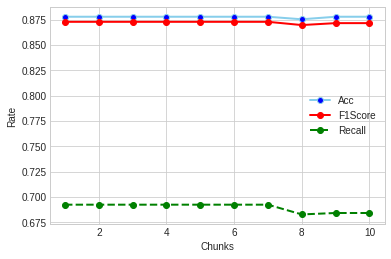

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# multiple line plot
plt.plot( 'Chunk', 'Acc', data=Tf_Idf_SVM, marker='o', markerfacecolor='blue' ,color='skyblue', linewidth=2)
plt.plot( 'Chunk', 'F1Score', data=Tf_Idf_SVM, marker='o', color='red', linewidth=2)
plt.plot( 'Chunk', 'Recall', data=Tf_Idf_SVM, marker='o', color='green', linewidth=2, linestyle='dashed')
plt.legend()
plt.xlabel("Chunks")
plt.ylabel("Rate")

* Hacer una representación de grupos
* Identificar términos relevantes


## W2Vec-SVM (Google Embbeding)

Se usa una representación entrenada por Google!




In [0]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [0]:
#Download google word2vec pretrained embedding 
#Referencia:https://colab.research.google.com/drive/1CXdKsk9mvHiuFMRowELp0NDP5__bsuVy#scrollTo=1DOpgwk6Y3rW

!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-10-13 04:10:25--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.113.205
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.113.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.5MB/s    in 97s     

2019-10-13 04:12:03 (16.1 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
dirW2VGoogle = '/root/input/GoogleNews-vectors-negative300.bin.gz'
tic=time.time()
model_google = KeyedVectors.load_word2vec_format(dirW2VGoogle, binary=True)
print('Tiempo de procesamiento (secs): ', time.time()-tic)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Tiempo de procesamiento (secs):  118.19308805465698


In [0]:
# Se obtiene las representaciones de los vectores de Google
def w2v_google(word,model=model_google):
    if word not in model.vocab:
        return 300*[0]
    else:
        return model[word]



In [0]:
# Dado un número devuelve su reciproco, si es cero se devuelve cero
def mydiag(x):
    if x==0:
        return (0)
    else:
        return (1/x)

In [0]:

def W2Vg_SVM(train,test,nChunks=1):
 
  # Generar datos
    x_train=generate_data(train,nChunks)
    y_train=train['Depress'].values
    x_test=generate_data(test,nChunks)
    y_test=test['Depress'].values
  
    # Ajustar BoW
    vectorizer_bow = CountVectorizer(max_features=1000)
    BoW = vectorizer_bow.fit_transform(x_train)

    # Obtener vocabulario 
    vocabulary=vectorizer_bow.get_feature_names()
    
    # Contenedor de las representaciones por palabras
    # El emmbedding tiene dimension 300, vamos a crear una matriz de embbeding
    # Con dimensiones (#nVocab,300)
    weigth_google=np.empty((0,300), float)
   

    # Obtener representaciones del vocabulario (matriz de embbedings)
    for word in vocabulary:
        weigth_google = np.vstack([weigth_google, w2v_google(word)])
             
    #Auxiliares de entrenamiento: Se obtiene una representación promedio
    # de cada documento en función de la cantidad de palabras
    # Una combinación lineal con la matriz de embbedings
    
    DocTec=BoW.toarray()    
    diag=np.diag(list(map(mydiag,DocTec.sum(axis=1))))
    
    # Datos para entrenamiento
    X_train_google=diag@DocTec@weigth_google
   
    # Datos para prueba
    Bow_test=vectorizer_bow.transform(x_test)
    DocTec_test=Bow_test.toarray()
    diag=np.diag(list(map(mydiag,DocTec_test.sum(axis=1))))
    X_test_google=diag@DocTec_test@weigth_google
   
    
    # SVM
    
    #  Ajustar clasificador
    clf_google = LinearSVC(tol=1e-5,C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
         intercept_scaling=1, loss='squared_hinge', max_iter=1000,
         multi_class='ovr', penalty='l2', random_state=1013, verbose=2)
 
    #Ajustar  modelo SVM-W2V-Google
    clf_google.fit(X_train_google,y_train)
    
    # Valores de prueba Google
    pred_test_google=clf_google.predict(X_test_google)
    
    # Métricas Google
    acc_g=metrics.accuracy_score(y_test,pred_test_google)
    f1_score_g=metrics.f1_score(y_test,pred_test_google,average='weighted')
    recall_score_g=metrics.recall_score(y_test,pred_test_google,average='macro')
    
    metrics_g=[nChunks,acc_g, f1_score_g,recall_score_g]
    
    
    return [round(metric,3) for metric in metrics_g]


In [0]:
w2v_svm_metrics=np.zeros(shape=(10,4))

for chunk in range(1,11):
  tic=time.time()
  w2v_svm_metrics[chunk-1,]=W2Vg_SVM(train_df,test_df,chunk)
  print('Chunks:{} Tiempo de procesamiento (secs):{}'.format(chunk,time.time()-tic))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [0]:
W2v_SVM=pd.DataFrame(w2v_svm_metrics, columns=['Chunks','Acc','F1Score','Recall'])
W2v_SVM

,Chunks,Acc,F1Score,Recall
0,1.0,0.753,0.786,0.695
1,2.0,0.753,0.786,0.695
2,3.0,0.788,0.813,0.723
3,4.0,0.791,0.815,0.724
4,5.0,0.798,0.822,0.737
5,6.0,0.798,0.820,0.720
6,7.0,0.813,0.834,0.753
7,8.0,0.820,0.842,0.790
8,9.0,0.813,0.836,0.786
9,10.0,0.820,0.842,0.790


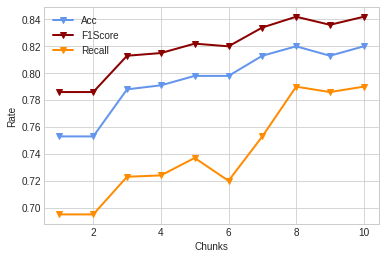

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# multiple line plot
plt.plot( 'Chunks', 'Acc', data=W2v_SVM, marker='v', color='cornflowerblue', linewidth=2)
plt.plot( 'Chunks', 'F1Score', data=W2v_SVM, marker='v', color='darkred', linewidth=2)
plt.plot( 'Chunks', 'Recall', data=W2v_SVM, marker='v', color='darkorange', linewidth=2)
plt.xlabel("Chunks")
plt.ylabel("Rate")
plt.legend()